In [1]:
from ATARI.theory.resonance_statistics import make_res_par_avg
import ATARI.utils.hdf5 as h5io
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import importlib
import os
from copy import copy
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator

from ATARI.models.particle_pair import Particle_Pair
from ATARI.models.experimental_model import experimental_model


In [2]:
%matplotlib widget

# Define a reaction model with the particle pair class

Look at open MC for user interface inspiration

In [3]:
Ta_pair = Particle_Pair("Ta181",
                        formalism="XCT",
                        ac = 8.1271,     # scattering radius
                        M = 180.948030,  # amu of target nucleus
                        m = 1,           # amu of incident neutron
                        I = 3.5,         # intrinsic spin, positive parity
                        i = 0.5,         # intrinsic spin, positive parity
                        l_max = 2)       # highest order l-wave to consider

Ta_pair.map_quantum_numbers(True)

Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D_avg=8.79,
                       Gn_avg=46.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)

# Ta_pair.add_spin_group(Jpi='4.0',
#                        J_ID=2,
#                        D_avg=4.99,
#                        Gn_avg=35.5,
#                        Gn_dof=1,
#                        Gg_avg=64.0,
#                        Gg_dof=1000)


energy_range = [200, 250]
resonance_ladder = Ta_pair.sample_resonance_ladder(energy_range)
resonance_ladder


The following arrays describe all possible spin groups for a each parity.
    The data is given as a tuple where the first value is the integer 
    or half integer total quantum spin J and the second value is the 
    number of entrance channels for that spin group. 
    * See the dictionary "possible_Jpi" for a nested packing structure.

Spin group data for all parity
(Jpi, #Chs, l-waves)
(-5.0, 1, [1])
(-4.0, 2, [1, 1])
(-3.0, 2, [1, 1])
(-2.0, 1, [1])
(1.0, 1, [2])
(2.0, 2, [2, 2])
(3.0, 3, [0, 2, 2])
(4.0, 3, [0, 2, 2])
(5.0, 2, [2, 2])
(6.0, 1, [2])


,E,Gg,Gn1,J,J_ID,varyE,varyGg,varyGn1
0,205.58159,63.786878,1.535012,3.0,1,0.0,0.0,0.0
1,213.510512,65.983169,2.174785,3.0,1,0.0,0.0,0.0
2,222.214957,55.183256,0.007079,3.0,1,0.0,0.0,0.0
3,230.622036,68.10105,3.170627,3.0,1,0.0,0.0,0.0
4,239.051787,65.514956,110.339256,3.0,1,0.0,0.0,0.0
5,241.850184,58.417772,112.231027,3.0,1,0.0,0.0,0.0


# Define experimental models

In [5]:
exp_model_T = experimental_model("T12mm", "transmission", [200,250],
                               
                                    parameters={
                                        'FP':(35.185,0.01),
                                        't0': (3.326, 0.0)
                                        } ,

                                    channel_width_info={
                                          "maxE": [500], 
                                          "chw": [100.0],
                                          "dchw": [0.8]
                                          }
                                                                  )


exp_model_Y = experimental_model("Y1mm", "capture", [200,250],
                               
                                    parameters={
                                        'FP':(100.14,0.01),
                                        't0':(2.0, 0.0)
                                        } ,

                                    channel_width_info={
                                          "maxE": [500], 
                                          "chw": [100.0],
                                          "dchw": [0.8]
                                          }
                                                                  )

exp_model_Y

inputs:
{'alphanumeric': ['USE MULTIPLE SCATTERING', 'INFINITE SLAB', 'NORMALIZE AS YIELD Rather than cross section', 'BROADENING IS WANTED', 'DO NOT SHIFT RPI RESOLUTION'], 'ResFunc': 'RPI C'}
parameters:
{'n': (0.067166, 0.0), 'FP': (100.14, 0.01), 't0': (2.0, 0.0), 'burst': (10, 1.0), 'temp': (300, 0.0)}
channel_width_info:
{'maxE': [500], 'chw': [100.0], 'dchw': [0.8]}

# Calculate theoretical with sammy

In [6]:
# calculate experimentally corrected transmission or capture yield with sammy

importlib.reload(template_creator)
importlib.reload(sammy_functions)

rto = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                             {"Print"   :   True,
                              "bayes"   :   False,
                              "keep_runDIR"     : True,
                              "sammy_runDIR": "sammy_runDIR_1"
                              })

template_creator.make_input_template('template_T.inp', Ta_pair, exp_model_T, rto)
template_creator.make_input_template('template_Y.inp', Ta_pair, exp_model_Y, rto)


In [7]:

datasets = [exp_model_T.energy_grid, exp_model_Y.energy_grid] 
experiments= [exp_model_T, exp_model_Y] 

templates = [os.path.realpath('template_T.inp'),os.path.realpath('template_Y.inp')]

sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = resonance_ladder,  

    datasets= datasets,
    templates= templates,
    experiments = experiments,
    )

sammyOUT = sammy_functions.run_sammy_YW(sammyINPyw, rto)


In [8]:
### define a dataframes to hold the true value with column key 'true' 

true_dfs = []
for i, exp in enumerate(experiments):
    true_df = copy(sammyOUT.pw[i])
    if exp.reaction == "transmission":
        true = "theo_trans"
    elif exp.reaction == "capture":
        true = "theo_xs"
    else:
        raise ValueError()

    assert(isinstance(true_df, pd.DataFrame))
    true_df = true_df[["E",true]]
    true_df.rename(columns={true:"true"}, inplace=True)

    true_dfs.append(true_df)


In [9]:
# o = np.linspace(1000, 1100, 1000)
# do = np.sqrt(o)

# T = np.linspace(0,1, 1000)
# s = np.log(T*o)
# ds = np.sqrt(s)

# # dT = np.sqrt( (1/o * ds)**2 + ((s/o**2)*do)**2)
# dT = np.sqrt()


# figure()

# # plot(T,np.sqrt(T)/20, label='sqrt(T)')
# # plot(o,do)
# plot(T,s)
# plot(T,dT, label="dT")
# # plot(synT.data.exp, synT.data.exp_unc, '.')
# # plot(synT.data.true, synT.data.exp_unc, '.')

# # plot(synT.raw_data.c, synT.data.exp, '.')
# # plot(synT.neutron_spectrum.dc, synT.data.exp, '.')

# # plot(synT.data.exp, np.sqrt(synT.data.exp))

# legend()

# Run Syndat experiment for each dataset

In [10]:

### pass true dataframe to syndat 

from ATARI.models.T_reduction_rpi import transmission_rpi
from ATARI.models.Y_reduction_rpi import yield_rpi
from ATARI.syndat.control import syndat

generation_T1 = transmission_rpi()
reduction_T1 = transmission_rpi()

synT = syndat(options={})
synT.run(true_dfs[0], generation_T1, reduction_T1, exp_model_T)


generation_C1 = yield_rpi()
reduction_C1 = yield_rpi()

synY = syndat(options={})
synY.run(true_dfs[1], generation_C1, reduction_C1, exp_model_Y)

In [11]:
# synT.neutron_spectrum

In [12]:
# from ATARI.syndat.general_functions import neutron_background_function


# figure()

# plot(np.linspace(0, 1000, 10000), neutron_background_function(np.linspace(0, 1000, 10000),
#      generation_T1.reduction_parameters["a_b"][0][0], generation_T1.reduction_parameters["a_b"][0][1]))
# xscale('log')

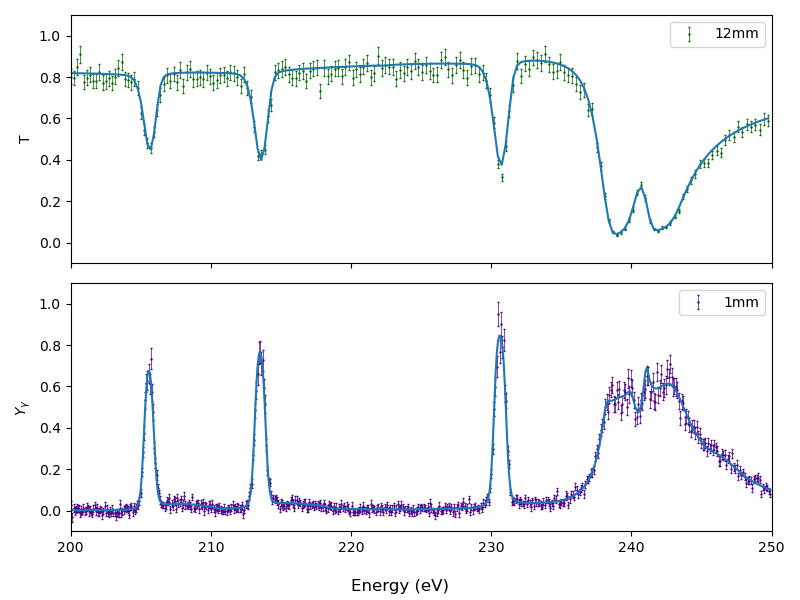

In [13]:
### Plot 

fig, axes = subplots(2,1, figsize=(8,6), sharex=True)

### Trans
axes[0].errorbar(synT.data.E, synT.data.exp, yerr=synT.data.exp_unc, zorder=0,
                                        fmt='.', color='darkgreen', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

axes[0].plot(synT.data.E, synT.data.true)
axes[0].set_ylabel("T")

### Capture
axes[1].errorbar(synY.data.E, synY.data.exp, yerr=synY.data.exp_unc, zorder=0, 
                                        fmt='.', color='indigo', linewidth=0.5, markersize=1.5, capsize=1, label='1mm')
axes[1].plot(synY.data.E, synY.data.true)

axes[1].set_ylabel(r"$Y_{\gamma}$")

### make it pretty
for ax in axes:
    ax.set_xlim([200,250])
    ax.set_ylim([-0.1,1.1])
    ax.legend()

fig.supxlabel('Energy (eV)')
fig.tight_layout()

In [14]:
# rel_unc = synT.data.exp_unc/synT.data.exp
# figure()
# _ = hist(rel_unc)

## Syndat class

Options:
1. starting from real data or not
2. measurement type (capture, transmission)
3. Sampling options
4. reduction parameters

### Notes
resolution function parameters need not be sampled if true uncertainty because the uncertainty is represented by the experimental model (resolution function) if the parameters were sampled on the generative side then the resolution function would be different for the fit - this would be like testing USU

I'm not sure about n parameter, if this is uncertain, it should be sampled and uncertainty should be propagated in the data reduction - I think this value can be fited in sammy if it is uncertain

Need to add a 'true uncertainty' option:
1. if true: true_underlying_reduction_parameters will be sampled from same mean/std as given by reduction_parameters
2. if false: true_underlying_reduction_parameters will be samled from different mean/std than given by reduction_parameters

In [ ]:

# class syndat:

#     def __init__(self, true: pd.DataFrame, experimental_model):
#         self.true = true
#         self.experimental_model = experimental_model

#         # maybe do some stuff about the energy gridding, maybe I dont need to supply true

#     def run(self, reduction_parameters = {}):


#         if self.experimental_model.reaction == "capture":
#             assert(np.isfinite(self.true.theo_xs))
#             # do capture


#         if self.experimental_model.reaction == "transmission":
#             assert(np.isfinite(self.true.theo_trans))
#             # do transmission



In [ ]:

# jb_df = pd.read_csv("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JB_sol/JB_reduction_data.csv", index_col='Unnamed: 0')
# jb_cov = np.load("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JB_sol/JB_cov.npy")
# jb_sys = np.load("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JB_sol/JB_syst.npy")
# jb_stat = np.load("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JB_sol/JB_stat.npy")
# jb_df['bw'] = jb_df.bw*1e-6
# realdat = jb_df.loc[(jb_df.e < 120) & (jb_df.e > 3)]


transdat12 = sammy_functions.readlst(
    "/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/trans-Ta-12mm.dat")
exptrans12 = experimental_model("trans12",
                                "transmission",
                                [2, 120],

                                inputs={
                                    'alphanumeric':   ["BROADENING IS WANTED"],
                                    'ResFunc':   "ORRES"
                                },

                                parameters={
                                    'n': (0.067166, 0.0),
                                    'FP': (35.185, 0.0),
                                    'burst': (8, 0.0),
                                    'temp': (294.2610, 0.0)},

                                channel_width_info={
                                    "maxE": [270],
                                    "chw": [102.7],
                                    "dchw": [0.8]
                                },

                                additional_resfunc_lines=["WATER 0004 5.6822000 -0.54425 0.07733000", "WATER      0.5000000  0.05000 0.00700000", "LITHI 000  -1.000000  -1.0000 6.00000000",
                                                          "LITHI      0.1000000  0.10000 0.60000000", "LITHI      166.87839 -28.7093 1.260690", "LITHI      0.2574580 -0.06871 0.004915"]
                                )

transdat12 = transdat12[(transdat12.E < max(exptrans12.energy_range)) & (
    transdat12.E > min(exptrans12.energy_range))]

In [ ]:
from ATARI.syndat.control import syndat
from ATARI.models.Y_reduction_rpi import yield_rpi
from ATARI.models.T_reduction_rpi import transmission_rpi

# fit from jeff


# sammyRTO = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
#                                              {"Print":   True,
#                                               "bayes":   False,
#                                               "keep_runDIR": False
#                                               })

# matnum = 7328
# jeff_file = "/Users/noahwalton/research_local/data/JEFF33_endf6/73-Ta-181g.jeff33"
# jeff_parameters = sammy_functions.get_endf_parameters(
#     jeff_file, matnum, sammyRTO)

# jeff_parameters = jeff_parameters[(
#     jeff_parameters.E < 120) & (jeff_parameters.E > 2)]
# jeff_parameters["varyGn1"] = np.ones(len(jeff_parameters))*1
# jeff_parameters["varyGg"] = np.ones(len(jeff_parameters))*1
# jeff_parameters["varyE"] = np.ones(len(jeff_parameters))*1


# datasets = [transdat12]
# experiments = [exptrans12]
# # templates = [os.path.realpath('template_T.inp')]
# templates = []
# for data, exp in zip(datasets, experiments):
#     filepath = f'template_{exp.title}'
#     # templates are already made and edited!
#     template_creator.make_input_template(filepath, model, exp, rto)
#     templates.append(os.path.realpath(filepath))

# sammyINPyw = sammy_classes.SammyInputDataYW(
#     particle_pair=Ta_pair,
#     model=model,
#     resonance_ladder=jeff_parameters,

#     datasets=datasets,
#     templates=templates,
#     experiments=experiments,

#     max_steps=20,
#     iterations=2,
#     step_threshold=0.01,
#     autoelim_threshold=None,

#     LS=False,
#     LevMar=True,
#     LevMarV=1.5,
#     # LevMarVd=5,
#     initial_parameter_uncertainty=0.1
# )

# sammyRTO.bayes = True
# sammyRTO.keep_runDIR = True
# sammyOUT = sammy_functions.run_sammy_YW(sammyINPyw, sammyRTO)

### Randomly sampled resonances ladders
Usually produces a similar signal to noise ratio unless the resonance ladder is drastically different, could look at average over many repetitions? Want to match 

In [ ]:

sammyRTO = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                                             {"Print":   True,
                                              "bayes":   False,
                                              "keep_runDIR": False
                                              })


datasets = [transdat12]
experiments = [exptrans12]
# templates = [os.path.realpath('template_T.inp')]
templates = []
for data, exp in zip(datasets, experiments):
    filepath = f'template_{exp.title}'
    template_creator.make_input_template(filepath, model, exp, rto)
    templates.append(os.path.realpath(filepath))

res = Ta_pair.sample_resonance_ladder([2,120], spin_groups, average_parameters)

sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair=Ta_pair,
    model=model,
    resonance_ladder=res,

    datasets=datasets,
    templates=templates,
    experiments=experiments,
)

sammyOUT = sammy_functions.run_sammy_YW(sammyINPyw, sammyRTO)

In [ ]:

true_df = copy(sammyOUT.pw[0])
assert (isinstance(true_df, pd.DataFrame))
true_df = true_df[["E", "theo_trans"]]
true_df.rename(columns={"theo_trans": "true"}, inplace=True)


generation_T1 = transmission_rpi(reduction_parameters={'trigo':   (9758727,             0),
                                                       'trigs':   (18476117,            0)}
                                                       )
reduction_T1 = transmission_rpi(reduction_parameters={'trigo':   (9758727,             0),
                                                      'trigs':   (18476117,            0)}
                                                      )

synT = syndat(options={})
synT.run(true_df, generation_T1, reduction_T1)

(-0.1, 1.0)

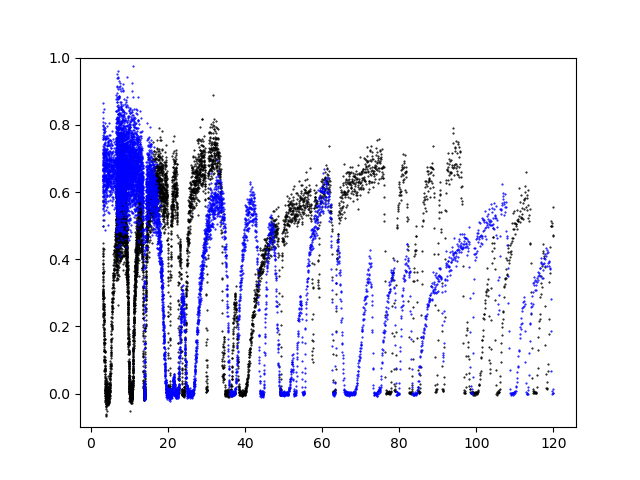

In [ ]:
figure()
plot(transdat12.E, transdat12.exp, 'k.', markersize=1)
plot(synT.data.E, synT.data.exp, 'b.', markersize=1)
# plot(synT.data.E, synT.data.true, 'b', markersize=1)
ylim([-0.1,1])

(0.0, 0.6714023436076302)

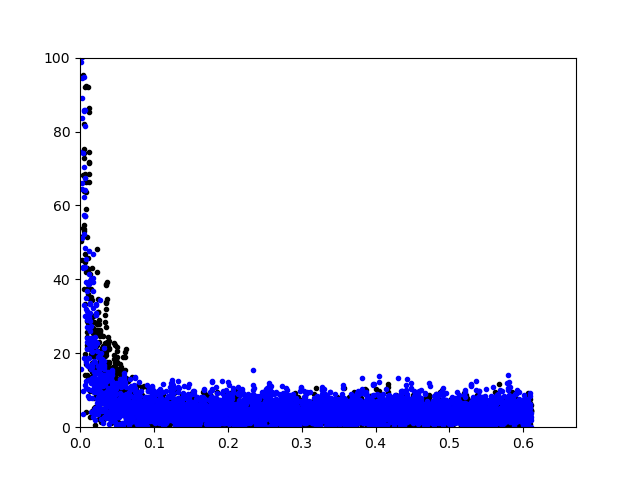

In [ ]:

freq = np.fft.fftfreq(len(synT.data.tof), synT.data.tof[1] - synT.data.tof[0])

Y = np.fft.fft(transdat12.exp)

Ysyn = np.fft.fft(synT.data.exp)
# P_signal = np.abs(Ysyn)**2
# P_noise = np.abs(Y[noise_indices])**2
# SNR = np.sum(P_signal) / np.sum(P_noise)

figure()
plot(freq, abs(Y), 'k.')
plot(freq, abs(Ysyn), 'b.')
ylim(-0.01, 100)
xlim(0)

# xscale('log')
# yscale('log')